In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Load the dataset
df = pd.read_csv(r"C:\Users\KIRAN\Desktop\Comprehensive Analytics Hub\Metro_Interstate_Traffic_Volume.csv", parse_dates=['date_time']) 

In [6]:
#Returns first 5 rows to ensure data is complete
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [7]:
#Returns the last 5 rows
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [8]:
# Sort by datetime for simulation
df = df.sort_values('date_time').reset_index(drop=True)

In [9]:
#Print the Length of dataset to divide and process in chunks
print(f"Dataset loaded with {len(df)} records.") 

Dataset loaded with 48204 records.


In [11]:
# Simulated streaming: processing in chunks
averages = []
chunk_size = 500
for start in range(0, len(df), chunk_size):
    chunk = df.iloc[start:start+chunk_size]
    avg_volume = chunk['traffic_volume'].mean() 
    averages.append(avg_volume)
    time.sleep(0.5)  # Simulate delay (adjust or remove as needed)
print("Processing complete.")
print(f"Total chunks processed: {len(averages)}")
print(f"Overall average traffic volume: {sum(averages) / len(averages):.2f}")

Processing complete.
Total chunks processed: 97
Overall average traffic volume: 3260.05


In [14]:
# Extract datetime features for later use
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

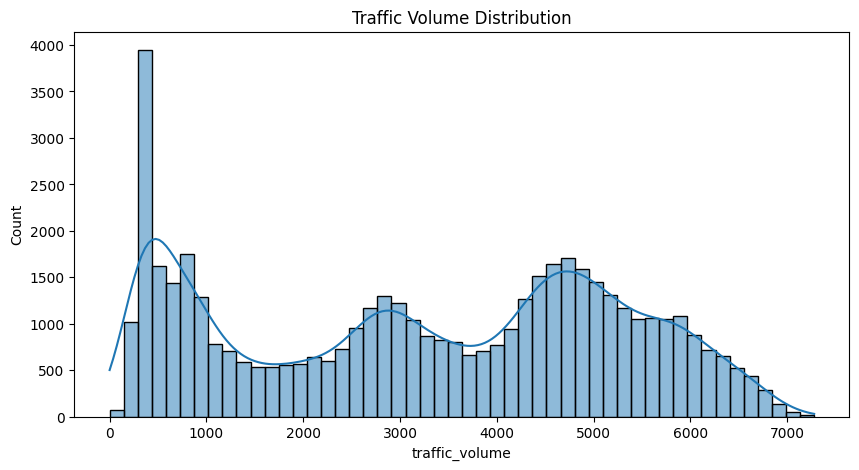

In [15]:
# Basic EDA plots
plt.figure(figsize=(10,5))
sns.histplot(df['traffic_volume'], bins=50, kde=True)
plt.title('Traffic Volume Distribution')
plt.show()

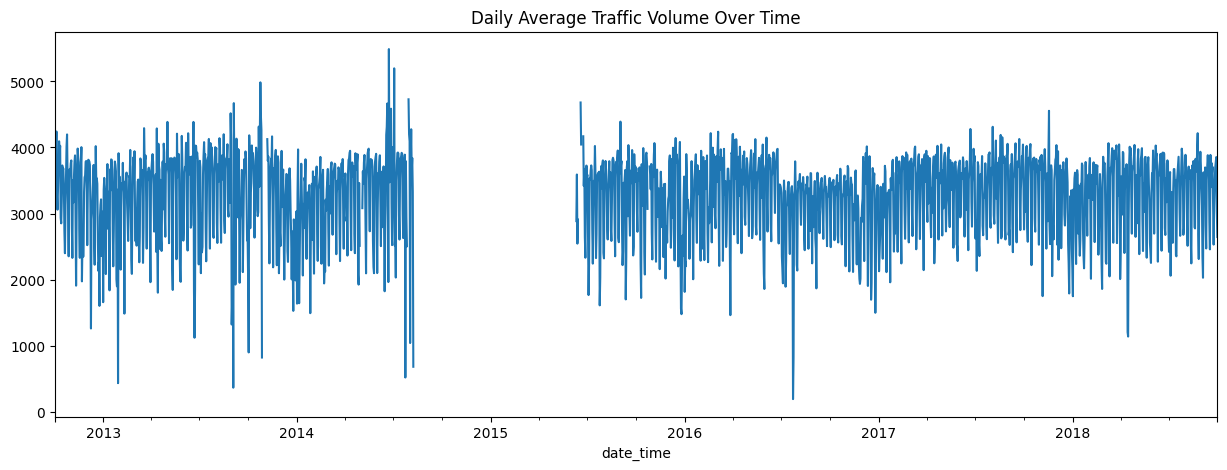

In [16]:
plt.figure(figsize=(15,5))
df.set_index('date_time')['traffic_volume'].resample('D').mean().plot()
plt.title('Daily Average Traffic Volume Over Time')
plt.show()

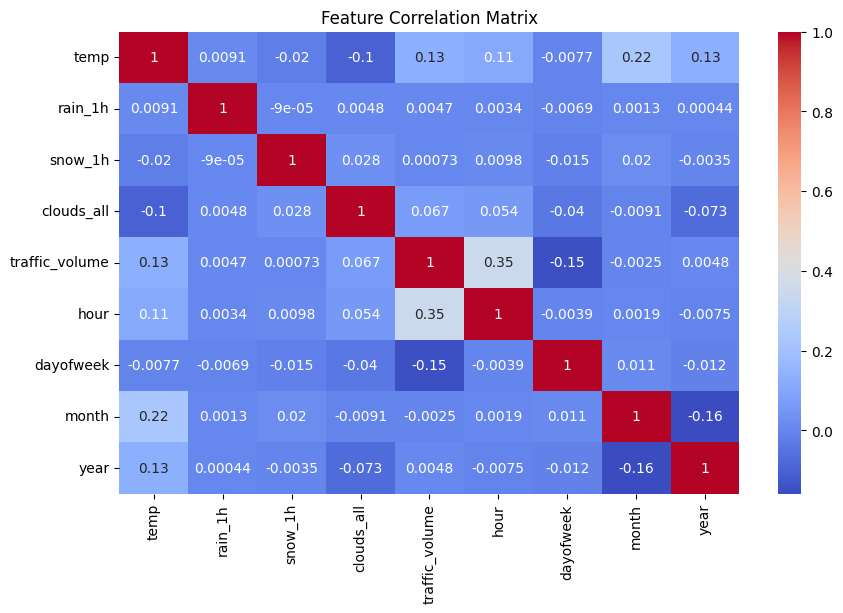

In [17]:
#Heatmaps
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [18]:
# Predictive Traffic-Volume Forecasting
# Feature columns for prediction
feature_cols = ['hour', 'dayofweek', 'month', 'temp', 'rain_1h', 'snow_1h', 'clouds_all'] 

In [19]:
# Prepare input and target variables
X = df[feature_cols]
y = df['traffic_volume'] 

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
y_pred = rfr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest RMSE on test set: {rmse:.2f}")

Random Forest RMSE on test set: 439.25


In [24]:
print(y_test.describe())

count    9641.000000
mean     3273.831449
std      1988.447554
min         1.000000
25%      1196.000000
50%      3420.000000
75%      4936.000000
max      7192.000000
Name: traffic_volume, dtype: float64


In [25]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 63.75%


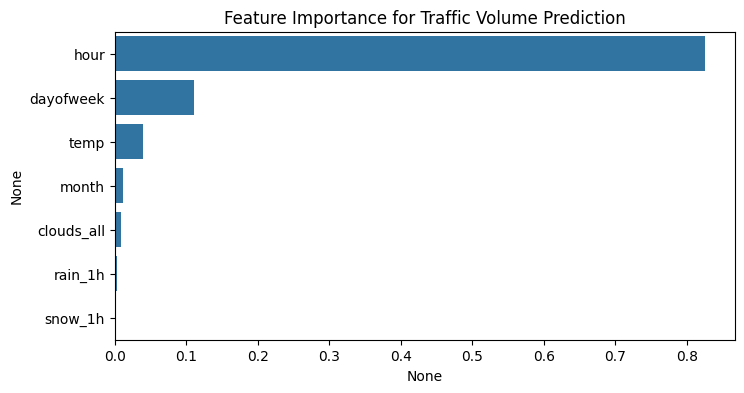

In [26]:
importances = pd.Series(rfr.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importance for Traffic Volume Prediction')
plt.show()

# Prepare time series data for LSTM
# We will predict traffic_volume based on previous 24 hours (lags)

In [29]:
# Use only traffic_volume column for LSTM
traffic_data = df[['date_time', 'traffic_volume']].copy()

In [30]:
# Normalize traffic_volume to [0,1]
scaler = MinMaxScaler()
traffic_data['traffic_volume_scaled'] = scaler.fit_transform(traffic_data[['traffic_volume']])

In [31]:
# Function to create sequences of data for LSTM
def create_sequences(data, seq_length=24):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [32]:
SEQ_LENGTH = 24  # previous 24 hours to predict next hour

# Prepare scaled data as numpy array
scaled_values = traffic_data['traffic_volume_scaled'].values

X_lstm, y_lstm = create_sequences(scaled_values, SEQ_LENGTH)

# Reshape X for LSTM input: (samples, timesteps, features)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))


In [33]:
# Split into train and test sets (80/20)
split_idx = int(len(X_lstm)*0.8)

X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [34]:
# Build LSTM Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LENGTH,1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train model (epochs can be increased for better accuracy)
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32,
                    validation_split=0.1)



Epoch 1/10

1085/1085 [==============================] - 17s 13ms/step - loss: 0.0157 - val_loss: 0.0063
Epoch 2/10
1085/1085 [==============================] - 13s 12ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 3/10
1085/1085 [==============================] - 13s 12ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 4/10
1085/1085 [==============================] - 15s 14ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 5/10
1085/1085 [==============================] - 14s 13ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 6/10
1085/1085 [==============================] - 12s 11ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 7/10
1085/1085 [==============================] - 14s 13ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 8/10
1085/1085 [==============================] - 13s 12ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 9/10
1085/1085 [==============================] - 15s 14ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 10/10
1085/1085 [==============================] - 14s 

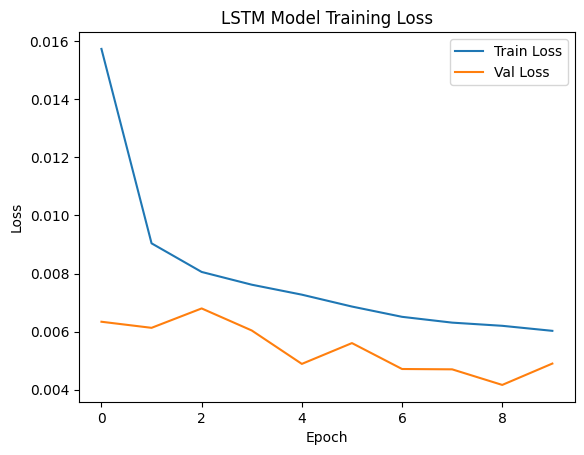

In [35]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Evaluate on test set
y_pred_lstm = model.predict(X_test_lstm)

302/302 [==============================] - 3s 8ms/step


In [37]:
# Inverse scale predictions and actuals
y_test_inv = scaler.inverse_transform(y_test_lstm.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred_lstm)

In [39]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mse)
print(f"LSTM Model RMSE on test set: {rmse_lstm:.2f}")

LSTM Model RMSE on test set: 473.94


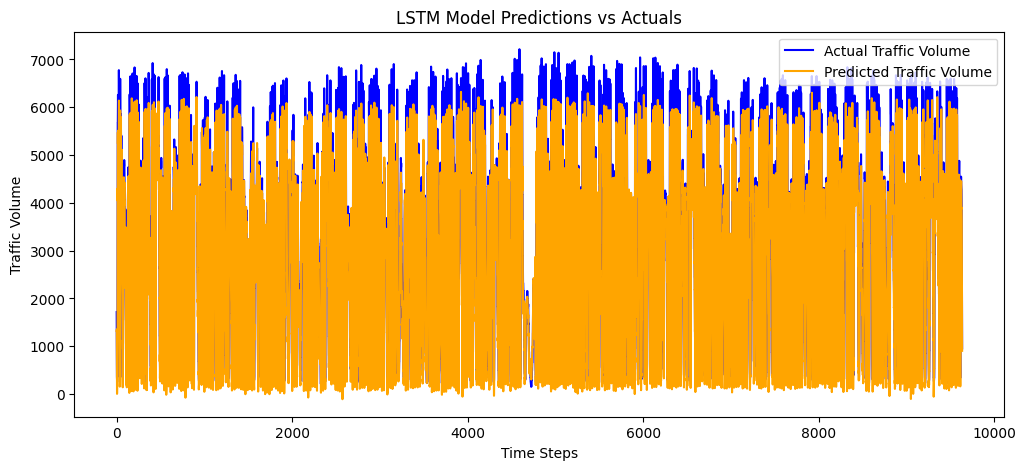

In [41]:
# Plot actual vs predicted traffic volume
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual Traffic Volume', color='blue')
plt.plot(y_pred_inv, label='Predicted Traffic Volume', color='orange')
plt.title('LSTM Model Predictions vs Actuals')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

# ## Step 4: Traffic Light Optimization with Google OR-Tools

In [43]:
from ortools.sat.python import cp_model

In [44]:
# Simplified scenario:
# Assume we have N intersections (or traffic signals)
# For each intersection, predicted traffic volume is known
# Objective: assign green light durations (within min/max bounds) to minimize overall waiting time

# For demo, we will simulate 5 intersections with predicted traffic volumes from our dataset
# Using average predicted traffic volumes per hour for each intersection

# Let's simulate predicted traffic volumes for 5 intersections at a certain time period
# For simplicity, pick 5 random hours and average traffic volumes for those hours

In [46]:
intersections = ['Int_A', 'Int_B', 'Int_C', 'Int_D', 'Int_E']
# Simulate predicted traffic volumes (vehicles per hour)
np.random.seed(42)
predicted_volumes = np.random.randint(200, 2000, size=len(intersections))
print("Simulated Predicted Traffic Volumes:")
for i, vol in enumerate(predicted_volumes):
    print(f"{intersections[i]}: {vol} vehicles/hr")

Simulated Predicted Traffic Volumes:
Int_A: 1326 vehicles/hr
Int_B: 1659 vehicles/hr
Int_C: 1060 vehicles/hr
Int_D: 1494 vehicles/hr
Int_E: 1330 vehicles/hr


In [47]:
# Model constraints:
# Each green light duration must be between 20 and 120 seconds
MIN_GREEN = 20
MAX_GREEN = 120

# Total cycle time fixed (e.g. 300 seconds)
TOTAL_CYCLE = 300

model = cp_model.CpModel()

# Decision variables: green light duration for each intersection (integer seconds)
green_durations = {}
for i in intersections:
    green_durations[i] = model.NewIntVar(MIN_GREEN, MAX_GREEN, f'green_{i}')

# Constraint: sum of green light durations = TOTAL_CYCLE
model.Add(sum(green_durations[i] for i in intersections) == TOTAL_CYCLE)

In [48]:
# Objective: minimize total weighted waiting time
# Assume waiting time inversely proportional to green light duration and proportional to volume

# Define an auxiliary variable for weighted waiting time at each intersection
waiting_times = []
for i, vol in zip(intersections, predicted_volumes):
    # We approximate waiting time = vol * (cycle - green_duration)
    # Here, cycle time is TOTAL_CYCLE
    wait_time = model.NewIntVar(0, TOTAL_CYCLE * vol, f'wait_{i}')
    model.Add(wait_time == vol * (TOTAL_CYCLE - green_durations[i]))
    waiting_times.append(wait_time)

model.Minimize(sum(waiting_times))

In [49]:
# Solve
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("\nOptimized Green Light Durations (seconds):")
    for i in intersections:
        print(f"{i}: {solver.Value(green_durations[i])} sec")
    print(f"\nTotal Cycle Time: {TOTAL_CYCLE} sec")
else:
    print("No solution found.")


Optimized Green Light Durations (seconds):
Int_A: 20 sec
Int_B: 120 sec
Int_C: 20 sec
Int_D: 120 sec
Int_E: 20 sec

Total Cycle Time: 300 sec


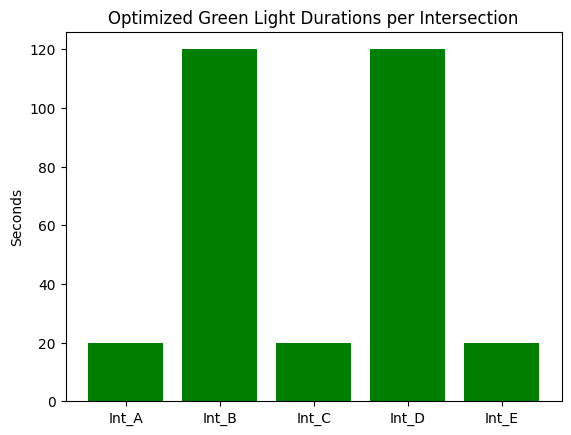

In [51]:
durations = [solver.Value(green_durations[i]) for i in intersections]
plt.bar(intersections, durations, color='green')
plt.title('Optimized Green Light Durations per Intersection')
plt.ylabel('Seconds')
plt.show()

# Step 5: Congestion Hotspot Detection & Visualization

In [54]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [55]:
# We'll use traffic_volume and time features for clustering congestion patterns
cluster_features = df[['traffic_volume', 'hour', 'dayofweek']]

In [56]:
# Normalize features for better clustering
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

In [57]:
# Apply KMeans clustering (choose 3 clusters as low, medium, high congestion)
kmeans = KMeans(n_clusters=3, random_state=42)
df['congestion_cluster'] = kmeans.fit_predict(cluster_features_scaled)

In [58]:
# Map clusters to congestion levels by average traffic volume
cluster_volumes = df.groupby('congestion_cluster')['traffic_volume'].mean().sort_values()
congestion_map = {cluster_volumes.index[0]: 'Low', cluster_volumes.index[1]: 'Medium', cluster_volumes.index[2]: 'High'}
df['congestion_level'] = df['congestion_cluster'].map(congestion_map)

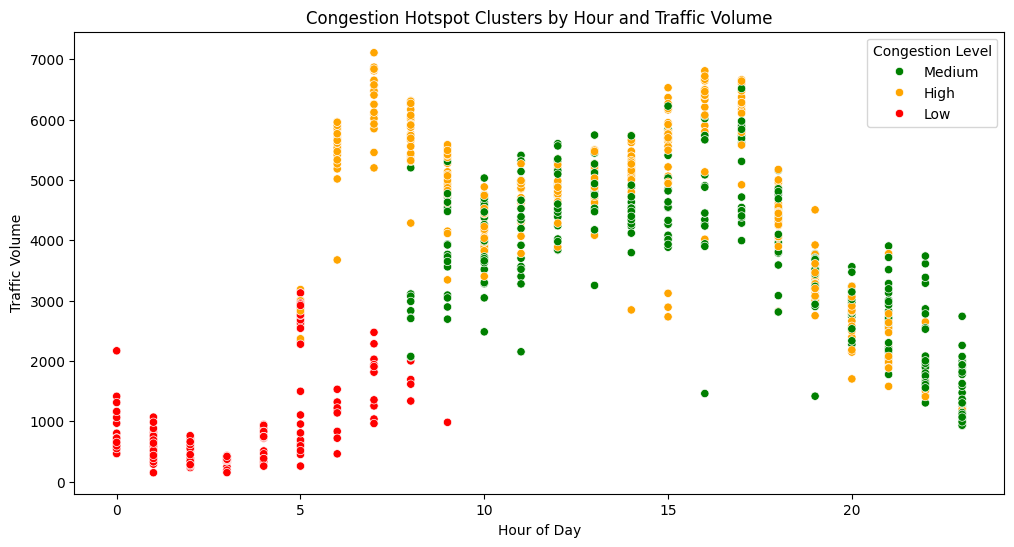

In [59]:
# Visualize clusters with scatter plot (hour vs traffic volume)
plt.figure(figsize=(12,6))
sns.scatterplot(data=df.sample(1000), x='hour', y='traffic_volume', hue='congestion_level', palette=['green','orange','red'])
plt.title('Congestion Hotspot Clusters by Hour and Traffic Volume')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume')
plt.legend(title='Congestion Level')
plt.show()

In [60]:
# Heatmap of congestion by hour and day of week
heatmap_data = df.groupby(['dayofweek', 'hour'])['traffic_volume'].mean().unstack()

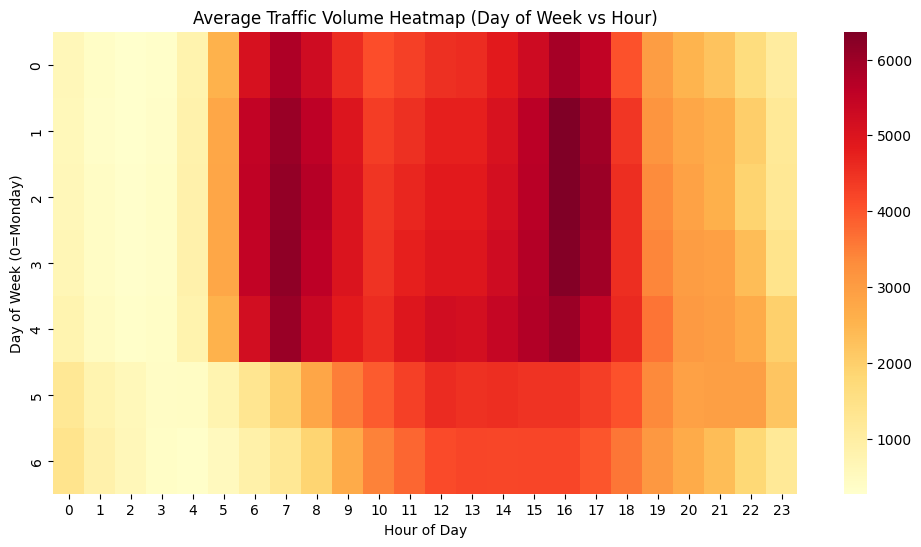

In [61]:
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlOrRd')
plt.title('Average Traffic Volume Heatmap (Day of Week vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday)')
plt.show()

# Step 6: Evaluation & Reporting Summary

In [62]:
print("=== Evaluation Summary ===")
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"LSTM Model RMSE: {rmse_lstm:.2f}")
print("\nCongestion Cluster Distribution:")
print(df['congestion_level'].value_counts())

=== Evaluation Summary ===
Random Forest RMSE: 439.25
LSTM Model RMSE: 473.94

Congestion Cluster Distribution:
congestion_level
High      19203
Medium    15511
Low       13490
Name: count, dtype: int64


In [69]:
print("\nData period covered:", df['date_time'].min().date(), "to", df['date_time'].max().date())
print(f"Total records processed: {len(df)}")


Data period covered: 2012-10-02 to 2018-09-30
Total records processed: 48204
